# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "peter"
ln1 = "martigny"
fn2 = "benoît"
ln2 = "choffin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_martigny_peter_and_choffin_benoît.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ then all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

Let us first demonstrate that $C = \{w \: | \: y_i(w^Tx_i + b) \geq 1 \: \forall i \in \{1,...,n\}\}$ is a convex set.

Let us take $\alpha \in [0,1]$ and $s$ and $t$ two elements of $C$. Then, we have:
$$y_i(s^Tx_i + b) \geq 1$$
and:
$$y_i(t^Tx_i + b) \geq 1$$
By multiplying these two inequalities by respectively $\alpha$ and $1 - \alpha$, we get:
$$\alpha y_i(s^Tx_i + b) \geq \alpha$$
and:
$$(1-\alpha)y_i(t^Tx_i + b) \geq (1-\alpha)$$
Summing these last inequalities leads us to:
$$\alpha y_i (s^Tx_i + b) + (1 - \alpha)y_i(t^Tx_i + b) \geq 1 \iff y_i(\alpha(s^Tx_i + b) + (1-\alpha)(t^Tx_i + b)) \geq 1$$
$$\iff y_i(\alpha s^Tx_i + \alpha b + (1-\alpha)t^Tx_i + (1-\alpha)b) \geq 1 \iff y_i((\alpha s + (1-\alpha)t)^Tx_i + b) \geq 1$$
We conclude that for any $\alpha \in [0,1]$, for any $s$ and $t$ in $C$, $\alpha s + (1-\alpha)t$ belong also to $C$. Therefore, $C$ is a convex set.


Now, let us show that $f : (w,b) \rightarrow \frac{1}{2}w^Tw$ is a convex function. One can easily see that the gradient of $f$ is given by:
$$\nabla f(w,b) = \left[\begin{array}{rr} w \\ 0 \end{array}\right]$$
and the Hessian is given by:
$$\nabla^2 f(w,b) = \left[\begin{array}{rrr} I_n & 0 \\ 0 ... 0 & 0 \end{array}\right]$$ with $I_n$ the identity matrix of dimension $n$. This matrix is symmetric positive definite and as a consequence, $f$ is convex.

As $f$ and $C$ are convex, the problem ($\mathcal{P}$) is convex.

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

Our problem may be rewritten as such: 

$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &G . w + b . y \succeq u
 \end{array}
 \right.
$$

where $G$ and $u$ are given in the upper text.

Let us write the Lagrangian of this problem. We have: 

$$
L(w, b, \mu) = \frac{1}{2}w^Tw + \mu^T(u - Gw - by)
$$

Now, let's write the function $g$ as:

$$
g(\mu) = max_{w, b} L(w, b, \mu)
$$

The optimization w.r.t. $w$ gives: 

$$
w = G^T\mu
$$

The "$b$" part in $L$ is a linear function of $b$, hence we take: 

$$
\mu^Ty = y^T\mu = 0
$$

Hence, the dual problem can be written as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \max_{\mu} &\frac{1}{2}\mu^TGG^T\mu + \mu^Tu - \mu^TGG^T\mu
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \preceq  0
 \end{array}
 \right .
$$

Which can be rewritten as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^TGG^T\mu - \mu^Tu
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \preceq  0
 \end{array}
 \right .
$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

For a new sample $x$, the value returned by the learned function is given by: 

$$
y = sign(w^Tx + b)
$$

We have proven in $Q2$ that, at the optimum, 

$$
w = G^T\mu = \sum_{i = 1}^n \mu_iy_ix_i
$$

Hence, we have, for a new sample $x$: 

$$
y = sign(\sum_{i = 1}^n \mu_iy_ix_i^Tx + b)
$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

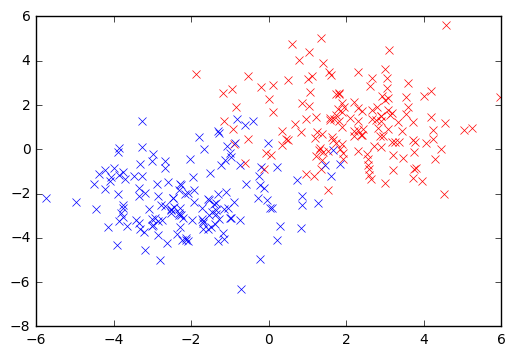

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


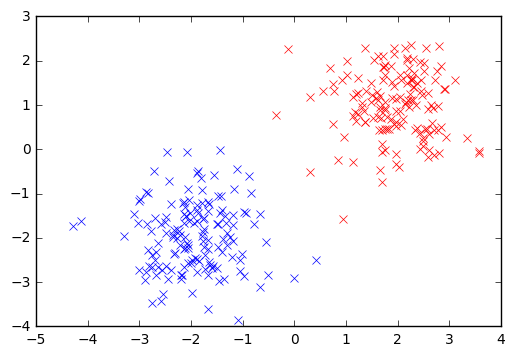

In [13]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    y_mat = np.dot(y.reshape(1,-1).T,y.reshape(1,-1))
    H = np.multiply(y_mat,K)
    e = np.ones(K.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [14]:
# TODO
w = np.sum((mu_support * y[idx_support]).reshape(1,-1).T * X[idx_support],axis=0)

- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

Let us find $b$: $y_i(w^tx_i + b) = 1 \iff w^tx_i + b = y_i^{-1} \iff b = y_i - w^tx_i$ since $y_i \in \{-1,+1\}$. We only need to use a support vector (i.e. a vector for which $\mu_i$ is non-zero).

In [15]:
# TODO

def compute_b(K, y, mu_support, idx_support):
    # TODO
    #We always choose the first support vector
    b = y[idx_support[0]] - np.sum(mu_support * y[idx_support] * [K[idx_support[0],j] for j in idx_support])
    return b

b = compute_b(K, y, mu_support, idx_support)

In [16]:
print b

1.25641084653


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [17]:
# TODO
def checkConstraint(y,w,X,b,epsilon=10**-5):
    listOfConstraints = [int(y[i]*(np.dot(w.T,X[i,:]) + b) < 1 - epsilon) for i in range(y.shape[0])]
    return np.sum(listOfConstraints)

In [18]:
print "There are " + str(checkConstraint(y,w,X,b)) + " samples that do not meet verify the primal constraint."

There are 0 samples that do not meet verify the primal constraint.


Check your code by running the following cell:

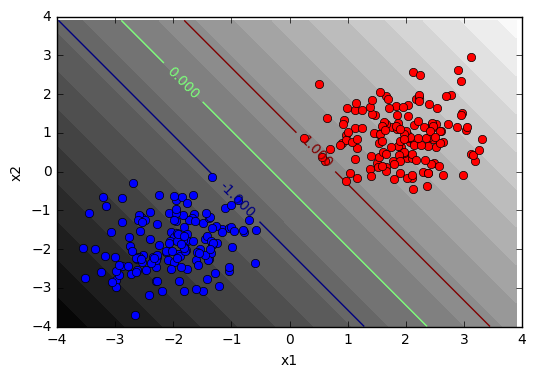

In [19]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

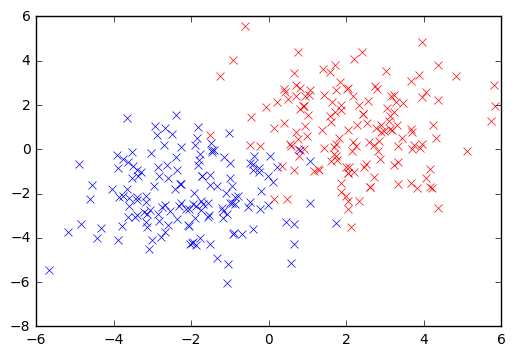

In [20]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [22]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

- Q8: Check that contraints of the problem are now violated.

In [23]:
# TODO
print "There are now " + str(checkConstraint(y,w,X,b)) + " samples that do not verify the primal constraint."

There are now 185 samples that do not verify the primal constraint.


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

We use the same argument as before:

Let us first demonstrate that $C = \{w \: | \: y_i(w^Tx_i + b) \geq 1 + \xi_i, \: \xi_i \geq 0, \: \forall i \in \{1,...,n\}\}$ is a convex set.

Let us take $\alpha \in [0,1]$ and $s$ and $t$ two elements of $C$. Then, we have:
$$y_i(s^Tx_i + b) \geq 1 + \xi_i$$
and:
$$y_i(t^Tx_i + b) \geq 1 + \xi_i$$
By multiplying these two inequalities by respectively $\alpha$ and $1 - \alpha$, we get:
$$\alpha y_i(s^Tx_i + b) \geq \alpha(1 + \xi_i)$$
and:
$$(1-\alpha)y_i(t^Tx_i + b) \geq (1-\alpha)(1 + \xi_i)$$
Summing these last inequalities leads us to:
$$\alpha y_i (s^Tx_i + b) + (1 - \alpha)y_i(t^Tx_i + b) \geq 1 + \xi_i \iff y_i(\alpha(s^Tx_i + b) + (1-\alpha)(t^Tx_i + b)) \geq 1 + \xi_i$$
$$\iff y_i(\alpha s^Tx_i + \alpha b + (1-\alpha)t^Tx_i + (1-\alpha)b) \geq 1 + \xi_i \iff y_i((\alpha s + (1-\alpha)t)^Tx_i + b) \geq 1 + \xi_i$$
We conclude that for any $\alpha \in [0,1]$, for any $s$ and $t$ in $C$, $\alpha s + (1-\alpha)t$ belong also to $C$. Therefore, $C$ is a convex set.


Now, let us show that $f : (w,b,\xi) \rightarrow \frac{1}{2}w^Tw + C \sum_i \xi_i$ is a convex function. One can easily see that the gradient of $f$ is given by:
$$\nabla f(w,b,\xi) = \left[\begin{array}{rr} w \\ 0 \\ 1 \\ . \\ . \\ . \\ 1\end{array}\right]$$
and the Hessian is given by:
$$\nabla^2 f(w) = ????$$ with $I_n$ the identity matrix of dimension $n$. This matrix is symmetric positive definite and as a consequence, $f$ is convex.

As $f$ and $C$ are convex, the problem ($\mathcal{P}$) is convex.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

Our problem may be rewritten as such: 

$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w + C \xi^T u
 \\
  &G . w + b . y \succeq u - \xi
 \end{array}
 \right.
$$

where \xi is the vector of values \xi_i

Let us write the Lagrangian of this problem. We have: 

$$
L(w, b, \mu) = \frac{1}{2}w^Tw + C \xi^T u + \mu^T(u - \xi - Gw - by)
$$

with \mu positive.

Now, let's write the function $g$ as:

$$
g(\mu) = max_{w, b, \xi} L(w, b, \xi, \mu)
$$

The optimization w.r.t. $w$ gives: 

$$
w = G^T\mu
$$

The optimization in b gives: 

$$
\mu^Ty = y^T\mu = 0
$$

The optimization in $\xi$ gives: 

$$
C u = \mu
$$

Hence, the dual problem can be written as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \max_{\mu} &\frac{1}{2}\mu^TGG^T\mu + \mu^Tu - \mu^TGG^T\mu
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \preceq  0, \mu \preceq C
 \end{array}
 \right .
$$

Which can be rewritten as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^TGG^T\mu - \mu^Tu
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& 0 \preceq \mu \preceq  C
 \end{array}
 \right .
$$

- Q10: Modify your code from Q4 to handle the non-separable case.

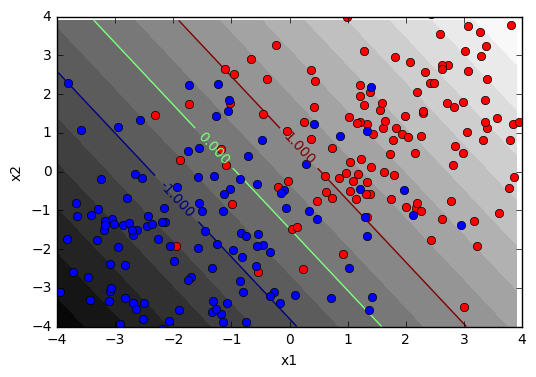

In [24]:
# TODO
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K,y,C=.1)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b)

In [25]:
listOfC = [.1,.2,.5,.8,1.,1.5,2.,4.,6.,10.]
for l in listOfC:
    mu_support, idx_support = svm_solver(K,y,C=l)
    print len(idx_support)

80
77
75
74
75
75
75
74
73
73


- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

We see from the previous cell that the greater the C, the fewer the number of support vectors.

When we use a great C, this means that we give a greater weight to the regularization induced by the slack variables. This means that we tolerate less the overlap.

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function $f(x)$ can be reformulated just using calls to $K$

We can reformulate the dual problem as follows:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}yy^{\top}K\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

And the decision function:

$$y = sign \left(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) \right)$$

We will use the clowns dataset to evaluate this:

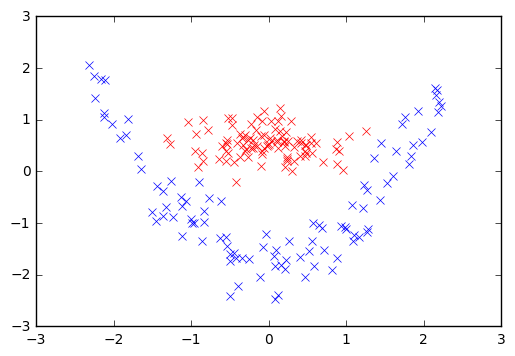

In [26]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [27]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*np.linalg.norm(X1[i] - X2[j])*2)  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

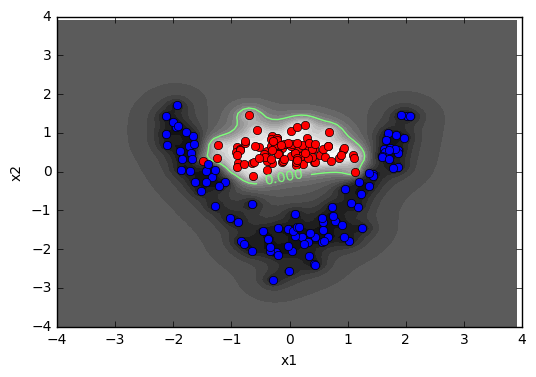

In [28]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

The same proof we used before works here, and since we do not consider the intercept term b the constraint $y^t\mu$ is no more present in the problem.

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

We can rewrite the dual in the form:

$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

with $f(\mu) = \frac{1}{2}\mu^{\top} G G^{\top} \mu - \mu^{\top}\mathbb{1}_n$ and $g(\mu)=\mathbb{1}_\mathcal{C}(\mu)$ with $\mathbb{1}_\mathcal{C}$ being the indicator function on $\mathcal{C} = [0 , C]^n$.

$g$ is clearly separable. Each $g_i$ is the same indicator function, but on $\mathbb{R}$ and not $\mathbb{R}^n$. $g$ is non-smooth because it is not continuously differentiable.

$f$ is continuously differentiable and $\nabla f(\mu) = \frac{1}{2} \times 2 K \mu - \mathbb{1}_n = K \mu - \mathbb{1}_n = GG^{\top}\mu - \mathbb{1}_n$ because $K$ is symmetric.

$$||\nabla f(x)-\nabla f(y)|| = ||Kx - Ky|| = ||K(x-y)|| \leq ||K||.||x-y||$$ Therefore, $f$ is ||K||-smooth.

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass through zero (due to absence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

First, we simulate some overlapped gaussian data:

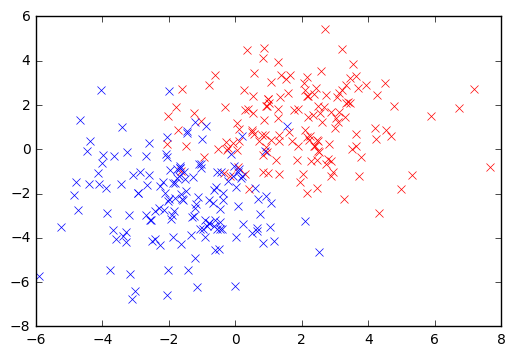

In [33]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plot_dataset(X, y)

In [30]:
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
K = kernel(X, X)

In [31]:
#Redefine solve_svm in order to obtain the complete vector of mu
def svm_solver(K, y, C=np.inf):
    y_mat = np.dot(y.reshape(1,-1).T,y.reshape(1,-1))
    H = np.multiply(y_mat,K)
    e = np.ones(K.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support, mu

mu_support, idx_support,mu_true = svm_solver(K,y,C=.1)

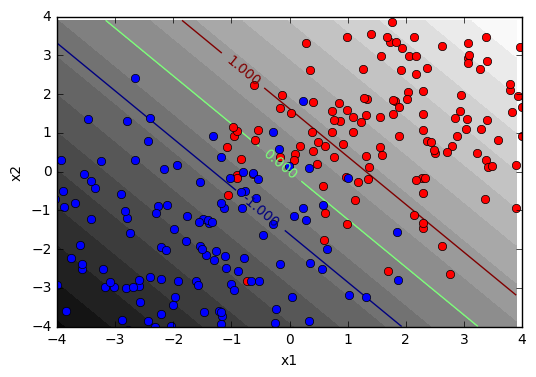

In [32]:
plot_classif(X[:,:2], y, mu_support, idx_support, b=0.)

In [67]:
#Some useful functions for what follows
from numpy.linalg import norm
from scipy.optimize import fmin_l_bfgs_b

def prox_svm(mu,C):
    """Proximal operator for the SVM without intercept"""
    temp1=np.where(mu < 0) #est-ce qu'on se laisse une marge, genre 1e-5?
    temp2=np.where(mu > C)
    mu[temp1]=0 
    mu[temp2]=C
    return mu

def svm_penalization(mu,C=.1):
    """Computes the value of the SVM penalization (indicator function of [0,C])"""
    if (min(mu) < 0) | (max(mu) > C):
        result= np.inf
    else:
        result=0.
    return result

def loss_svm(mu):
    """First function of the dual (f)"""
    result=(1./2)*np.dot(mu.T,np.dot(K,mu)) - np.sum(mu)
    return result

def grad_svm(mu):
    """Gradient of f"""
    result=np.dot(K,mu)-np.ones(mu.shape[0])
    return result

def lipschitz_svm(K):
    """Computes the Lipschitz constant of f (the highest eigenvalue of K works)"""
    L=norm(K)
    return L

def total_loss(mu,C=.1):
    result=loss_svm(mu)+svm_penalization(mu)
    return(result)

In [27]:
from numpy.random import randn
def ista(mu0, f, grad_f, g, prox_g, step,mu_true, C=.1, n_iter=500,verbose=True):
#(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         #x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    mu = mu0.copy()
    mu_new = mu0.copy()

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu,C)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        mu = prox_g(mu - step*grad_f(mu), C)
        obj = f(mu) + g(mu, C)
        err = norm(mu - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        if k % 100 == 0 and verbose:
             print(' | '.join([("%d" % k).rjust(8), 
                               ("%.2e" % obj).rjust(8), 
                               ("%.2e" % err).rjust(8)]))
    return mu, objectives, errors

In [29]:
mu0=randn(X.shape[0])
L=float(lipschitz_svm(K))
mu_test, objos,err=ista(mu0,loss_svm,grad_svm,svm_penalization,prox_svm,1./L,n_iter=5000,C=.1,mu_true=mu_true,verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.16e+02 | 1.48e+00
     100 | -4.87e-01 | 9.61e-01
     200 | -5.00e-01 | 9.65e-01
     300 | -5.00e-01 | 9.65e-01
     400 | -5.00e-01 | 9.65e-01
     500 | -5.00e-01 | 9.65e-01
     600 | -5.00e-01 | 9.65e-01
     700 | -5.00e-01 | 9.65e-01
     800 | -5.00e-01 | 9.65e-01
     900 | -5.00e-01 | 9.65e-01
    1000 | -5.00e-01 | 9.65e-01
    1100 | -5.00e-01 | 9.65e-01
    1200 | -5.00e-01 | 9.65e-01
    1300 | -5.00e-01 | 9.65e-01
    1400 | -5.00e-01 | 9.65e-01
    1500 | -5.00e-01 | 9.65e-01
    1600 | -5.00e-01 | 9.65e-01
    1700 | -5.00e-01 | 9.65e-01
    1800 | -5.00e-01 | 9.65e-01
    1900 | -5.00e-01 | 9.65e-01
    2000 | -5.00e-01 | 9.65e-01
    2100 | -5.00e-01 | 9.65e-01
    2200 | -5.00e-01 | 9.65e-01
    2300 | -5.00e-01 | 9.65e-01
    2400 | -5.00e-01 | 9.65e-01
    2500 | -5.00e-01 | 9.65e-01
    2600 | -5.00e-01 | 9.65e-01
    2700 | -5.00e-01 | 9.65e-01
    2800 | -5.00e-01 | 9.65e-01
    2900 | -5.00e-

In [30]:
idx_support_test = np.where(np.abs(mu_test) > 1e-5)[0]
mu_support_test = mu_test[idx_support_test]
w = np.sum((mu_support_test * y[idx_support_test]).reshape(1,-1).T * X[idx_support_test],axis=0)

In [31]:
def plot_classif2(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support,:2]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

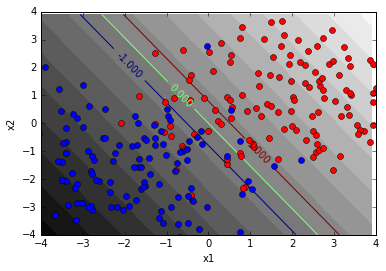

In [32]:
plot_classif2(X, y, mu_support_test, idx_support_test, b=0)

#### Accelerated proximal gradient (aka FISTA)

In [55]:
def fista(x0, f, grad_f, g, prox_g, step, mu_true,C=.1, n_iter=3,verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    mu = mu0.copy()
    mu_new = mu0.copy()
    # An extra variable is required for FISTA
    z = mu0.copy()   
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu, C)
    objectives.append(obj)
    
    t = 1.
    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        mu_new = prox_g(z - step*grad_f(z), C)
        t_new = (1 + np.sqrt(1 + 4*(t**2)))/2
        z_new = mu_new + ((t-1)/t_new)*(mu_new - mu)
        
        mu = mu_new
        t = t_new
        z = z_new
        
        obj = f(mu) + g(mu, C)
        err = norm(mu - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return mu, objectives, errors

In [58]:
mu_test, objos, err=fista(mu0,loss_svm,grad_svm,svm_penalization,prox_svm,1./L,n_iter=500,C=.1,mu_true=mu_true,verbose=True)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.16e+02 | 1.48e+00
      10 | 6.72e+00 | 9.56e-01
      20 | -3.39e-01 | 9.89e-01
      30 | -4.70e-01 | 9.75e-01
      40 | -5.00e-01 | 9.82e-01
      50 | -5.00e-01 | 9.79e-01
      60 | -5.00e-01 | 9.79e-01
      70 | -5.00e-01 | 9.78e-01
      80 | -5.00e-01 | 9.78e-01
      90 | -5.00e-01 | 9.78e-01
     100 | -5.00e-01 | 9.78e-01
     110 | -5.00e-01 | 9.78e-01
     120 | -5.00e-01 | 9.78e-01
     130 | -5.00e-01 | 9.78e-01
     140 | -5.00e-01 | 9.78e-01
     150 | -5.00e-01 | 9.78e-01
     160 | -5.00e-01 | 9.78e-01
     170 | -5.00e-01 | 9.78e-01
     180 | -5.00e-01 | 9.78e-01
     190 | -5.00e-01 | 9.77e-01
     200 | -5.00e-01 | 9.77e-01
     210 | -5.00e-01 | 9.77e-01
     220 | -5.00e-01 | 9.77e-01
     230 | -5.00e-01 | 9.77e-01
     240 | -5.00e-01 | 9.77e-01
     250 | -5.00e-01 | 9.77e-01
     260 | -5.00e-01 | 9.77e-01
     270 | -5.00e-01 | 9.77e-01
     280 | -5.00e-01 | 9.77e-01
     290 | -5.00e-

In [59]:
idx_support_test = np.where(np.abs(mu_test) > 1e-5)[0]
mu_support_test = mu_test[idx_support_test]
w = np.sum((mu_support_test * y[idx_support_test]).reshape(1,-1).T * X[idx_support_test],axis=0)

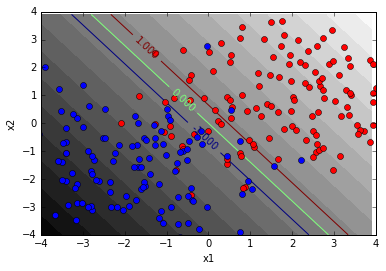

In [60]:
plot_classif2(X, y, mu_support_test, idx_support_test, b=0)

#### Coordinate gradient descent

In [ ]:
from numpy.random import randn
def ista(mu0, f, grad_f, g, prox_g, step,mu_true, C=.1, n_iter=500,verbose=True):
#(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         #x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    mu = mu0.copy()
    mu_new = mu0.copy()

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu,C)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        mu = prox_g(mu - step*grad_f(mu), C)
        obj = f(mu) + g(mu, C)
        err = norm(mu - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        if k % 100 == 0 and verbose:
             print(' | '.join([("%d" % k).rjust(8), 
                               ("%.2e" % obj).rjust(8), 
                               ("%.2e" % err).rjust(8)]))
    return mu, objectives, errors

In [ ]:
def cd_optim(mu0, f, grad_f, g, prox_g, step,mu_true, C=.1, n_iter=500,verbose=True):
    mu = mu0.copy()
    mu_new = mu0.copy()
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu,C)
    objectives.append(obj)
    
    

#### L-BFGS-B

In [61]:
#definition of the callback
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [62]:
bfgs_inspector = inspector(prox+g, mu_true, verbose=True)

NameError: name 'f' is not defined

In [70]:
mu_bfgs, f_min, dico = fmin_l_bfgs_b(total_loss, mu0, grad_svm, maxiter=1000)

In [71]:
mu_bfgs

array([  1.56217166e+00,  -3.26437480e-01,   5.34247789e-01,
        -4.31087262e-01,   1.27490760e+00,   9.74455401e-01,
         1.00181283e+00,  -4.34068453e-01,   1.82668607e+00,
         3.56873335e-01,   1.37567507e+00,   1.04537275e+00,
         2.91702063e-01,  -1.31207992e+00,  -8.14245973e-01,
         5.50151653e-01,   2.04435709e+00,   1.21221612e+00,
        -6.00826616e-01,   2.10729279e+00,  -5.31031026e-01,
         1.19668771e+00,  -7.10418010e-02,   4.99731950e-01,
         7.07089607e-01,   2.18187226e-01,   3.56666786e-01,
        -1.60097444e-01,  -1.86908772e-01,  -1.20639734e-01,
         2.23087359e-01,  -7.27081239e-01,   8.27399184e-01,
        -9.09217266e-01,   6.09024303e-01,  -2.00092324e-01,
         1.52289054e+00,   7.30880089e-02,  -3.32276755e-01,
        -8.11292863e-01,   1.10022784e-01,  -3.36189277e-01,
         1.98903031e+00,   4.45934882e-01,  -3.31535468e-01,
         1.49414548e-01,   1.06474860e+00,   1.69975188e+00,
        -2.46033351e-01,

In [72]:
np.where(np.abs(mu_bfgs) > 1e-5)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18